# Parameter Selection for NMF

Now we look at the more advanced task of parameter selection for NMF topic modelling - namely, selecting a useful value for the number of topics *k*.

Note that this notebook requires v4 of the [Gensim package](https://radimrehurek.com/gensim) to be installed.

In [17]:
from pathlib import Path
import re, joblib
from itertools import combinations
import numpy as np
from sklearn import decomposition
import gensim
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# settings for our plots later
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using *Joblib*:

In [18]:
(A,terms,snippets) = joblib.load("articles-tfidf.pkl")
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Loaded 3806 X 280 document-term matrix


### Create the Topic Models

A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of *k*.

We need to start by pre-specifying an initial range of "sensible" values:

In [19]:
kmin, kmax = 4, 15

Apply NMF for each of these values:

In [20]:
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=12 ...
Applying NMF for k=13 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=14 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=15 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


### Build a Word Embedding

To select the number of topics, here we will use a *topic coherence* measure called TC-W2V. This measure relies on the use of a *word embedding* model constructed from our corpus. So in this step we will use the *Gensim* implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

**Note:** If you want to skip this step, a pre-built Word2Vec model for the sample dataset [is also provided here for download](http://erdos.ucd.ie/files/pydata/w2v-model.bin) (71MB).

We read the documents from the input file again:

In [21]:
in_path = Path("data") / "file.txt"
raw_documents = []
with open(in_path, "r") as fin:
    # each line is a document
    for line in fin.readlines():
        raw_documents.append( line.strip().lower() )
print("Read %d raw text documents" % len(raw_documents))

Read 5748 raw text documents


Read the custom stopword list:

In [22]:
custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append(line.strip().lower())
# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 262 entries


First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

In [23]:
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

Now build a Skipgram Word2Vec model from all documents in the input file using *Gensim*:

In [24]:
docgen = TokenGenerator( raw_documents, custom_stop_words )
# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, vector_size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [25]:
print("Model has %d terms" % len(w2v_model.wv.key_to_index))

Model has 299 terms


Save for later use, so that we do not need to rebuild it:

In [26]:
w2v_model.save("w2v-model.bin")

In [27]:
# To re-load this model, run
#w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")

### Selecting the Number of Topics

Once we have our Word2vec model, we can use it as part of our *topic coherence* approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows:

In [28]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

In [29]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

Now process each of the models for different values of *k*:

In [30]:
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=0.9464
K=05: Coherence=0.9534
K=06: Coherence=0.9622
K=07: Coherence=0.9598
K=08: Coherence=0.9663
K=09: Coherence=0.9685
K=10: Coherence=0.9691
K=11: Coherence=0.9690
K=12: Coherence=0.9691
K=13: Coherence=0.9703
K=14: Coherence=0.9745
K=15: Coherence=0.9748


We can now use *matplotlib* to generate a line plot of these coherence scores, to help us select an appropriate value.

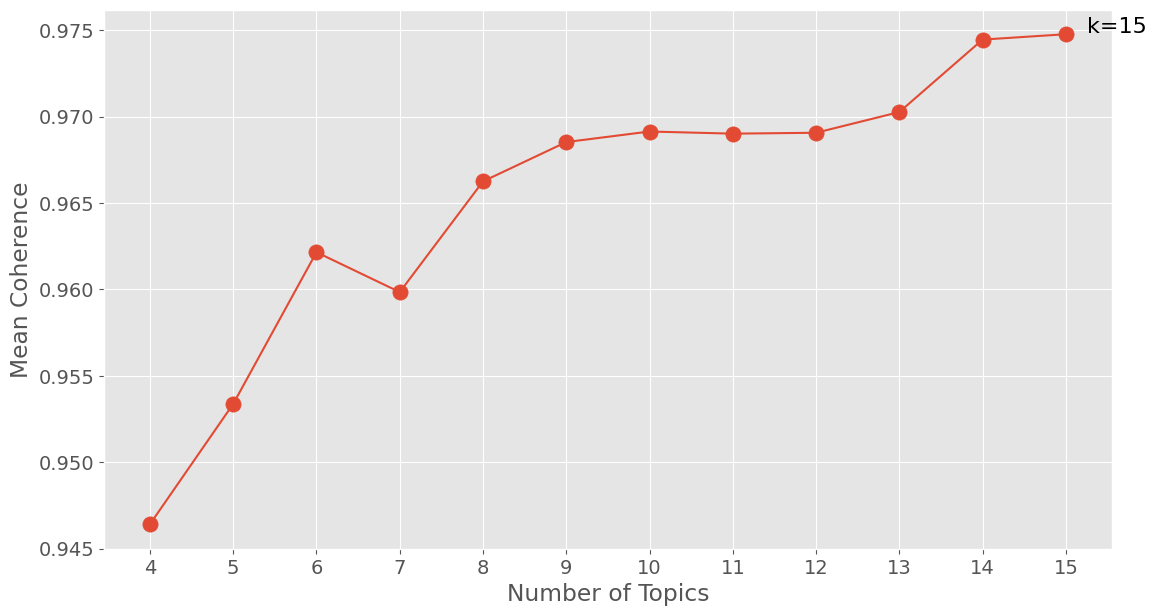

In [31]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter(k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate("k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

### Examine the Final  Model

The plot above suggests that the most appropriate value for the number of topics is *k=8*.

In [32]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

Display the topic descriptors for this model:

In [33]:
for topic_index in range(k):
    descriptor = get_descriptor(terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % (topic_index+1, str_descriptor) )

Topic 01: dkpol, dkgreen, fv19, mette, paludan, df, sundpol, valg, politiske, politikere
Topic 02: user, rt, tak, dkgreen, kære, pldk, dkbiz, sundpol, danmarks, rigtig
Topic 03: link, læs, dkbiz, danske, blevet, skrevet, uddpol, klar, skriver, europa
Topic 04: ret, faktisk, giver, vildt, give, politiet, står, netop, desværre, folk
Topic 05: dag, tv, direkte, kampe, pldk, tid, dkgreen, holder, viser, fodbold
Topic 06: dkmedier, paludan, skriver, læs, holder, spørgsmål, tv, fv19, medier, viser
Topic 07: tror, gå, tak, faktisk, viser, klar, folk, præcis, set, virker
Topic 08: år, sidste, 20, seneste, folk, blevet, 30, kæmpe, 15, danske
Topic 09: nye, dkbiz, penge, fald, hold, frem, eudk, svært, valget, kr
Topic 10: sldk, pldk, tv, fc, brøndby, kampe, direkte, fodbold, kamp, mål
Topic 11: danmark, df, dansk, eu, politik, vist, verden, nyheder, valg, hele
Topic 12: første, gang, inden, tid, én, paludan, dage, måde, blevet, 15
Topic 13: går, stedet, valg, artikel, tager, forstår, folk, debat